In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from utilities import *
from crossValidation import *
from features import *

In [5]:
# Data
# df1 = pd.read_csv('Analysis/data/full_5m_futures/ONTUSDT_futures_5m_202310_202404.csv', index_col=0)
# df2 = pd.read_csv('Analysis/data/full_5m_futures/ONGUSDT_futures_5m_202311_202404.csv', index_col=0)

df1 = pd.read_csv('Analysis/data/full_5m_futures/NEOUSDT_futures_5m_20231001_20240529.csv', index_col=0)
df2 = pd.read_csv('Analysis/data/full_5m_futures/GASUSDT_futures_5m_20231025_20240529.csv', index_col=0)

# df1 = pd.read_csv('Analysis/data/full_5m_futures/MANAUSDT_futures_5m_202103_202401.csv', index_col=0)
# df2 = pd.read_csv('Analysis/data/full_5m_futures/SANDUSDT_futures_5m_202101_202401.csv', index_col=0)

# df1 = pd.read_csv('Analysis/data/full_5m_spot/NEOUSDT_spot_5m_201711_202401.csv', index_col=0)
# df2 = pd.read_csv('Analysis/data/full_5m_spot/GASUSDT_spot_5m_202303_202401.csv', index_col=0)

# df1 = pd.read_csv('Analysis/data/full_5m_spot/ONTUSDT_spot_5m_202002_202402.csv', index_col=0)
# df2 = pd.read_csv('Analysis/data/full_5m_spot/ONGUSDT_spot_5m_202204_202402.csv', index_col=0)



df1.Time = pd.to_datetime(df1.Time, unit='ms')
df2.Time = pd.to_datetime(df2.Time, unit='ms')
df1.set_index('Time', inplace=True)
df2.set_index('Time', inplace=True)

# Pair Price
min_start = pd.to_datetime("2023-11-15")
common_start = max(df1.index[0], df2.index[0], min_start)
common_end = min(df1.index[-1],df2.index[-1])

df1 = df1[common_start:common_end]
df2 = df2[common_start:common_end]

<Axes: xlabel='Time'>

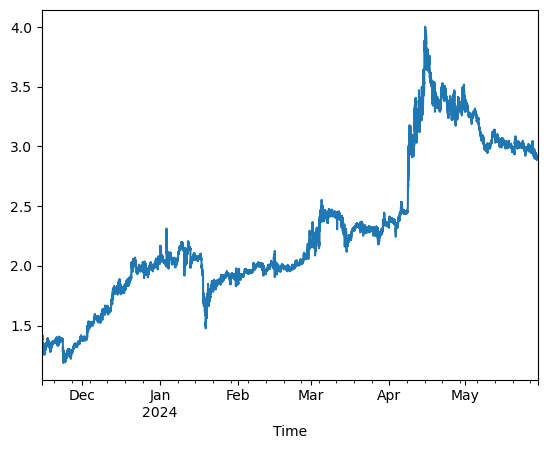

In [6]:
(df1.Close/df2.Close).plot()

In [8]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Add constant to the predictor
x_with_const = sm.add_constant(np.log(df2.Close))
y = np.log(df1.Close)

# Set the window size
n = 2000

# Create rolling OLS model
rolling_ols = RollingOLS(y, x_with_const, window=n)
result = rolling_ols.fit()

<Axes: xlabel='Time'>

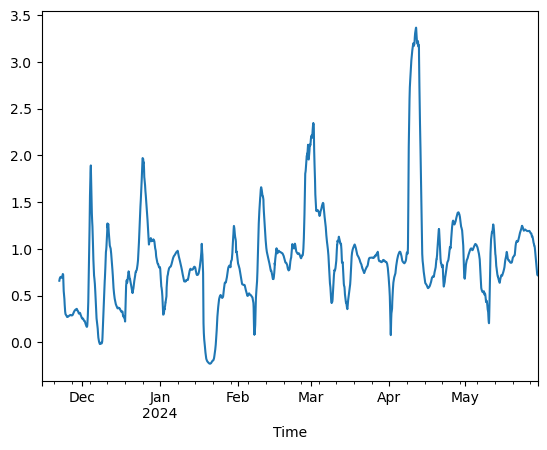

In [9]:
result.params.Close.plot()

In [10]:
cv_dates = []
for train, test in time_series_cv_dates(num_splits=4, start_date=common_start, end_date=common_end, warm_up_splits=1, gap_days=1):
    cv_dates.append({'train':train,'test':test})

In [11]:
len(cv_dates)

3

In [12]:
out = []

# Start Here

In [13]:
fold = 2

In [14]:
trainStart,trainEnd = cv_dates[fold]['train'][0],cv_dates[fold]['train'][1]
testStart,testEnd = cv_dates[fold]['test'][0],cv_dates[fold]['test'][1]
trainDays = (trainEnd-trainStart).days
testDays = (testEnd-testStart).days
print("Train Days:", trainDays)

Train Days: 142


In [58]:
trainDays_recent = 365
trainStart_recent = trainEnd - pd.Timedelta(days=trainDays_recent)

In [59]:
# Estimate Beta
beta_all = result.params.Close[trainStart:trainEnd].median()
beta_recent = result.params.Close[trainStart_recent:trainEnd].median()
beta = np.mean([beta_all, beta_recent])
# beta = beta_all
print(beta_all, beta_recent, beta)
# print(beta)

0.8138034033077057 0.8138034033077057 0.8138034033077057


In [60]:
# Estimate Spread and Volatility
spread = np.log(df1)-np.log(df2)*beta
spread['barID'] = spread.reset_index().index.values
spread['vol'] = spread.Close.rolling(100).std()

<Axes: xlabel='Time'>

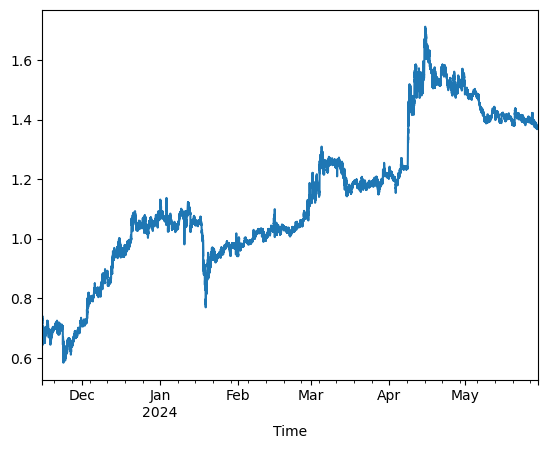

In [61]:
spread.Close.plot()

In [71]:
testStart,testEnd

(Timestamp('2024-04-07 00:00:00'), Timestamp('2024-05-29 23:55:00'))

In [73]:
# Bollinger Sampling
lookback = 100
feat = getBollinger(spread.Close, lookback, use_log = False)
# feat = getTrendBlgr(spread.index[lookback:], spread.Close, lookback, 4, use_log=False)
entry_quantiles = feat.mean() + feat.std()*np.linspace(-3,3, 100)


In [74]:
exit_thres1 = 0
exit_thres2 = None

tradingDays = 365
commission = 0.001
minVol = commission * 3
targetVol = 0.015

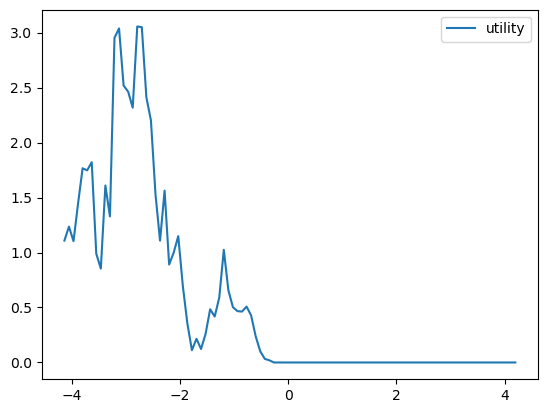

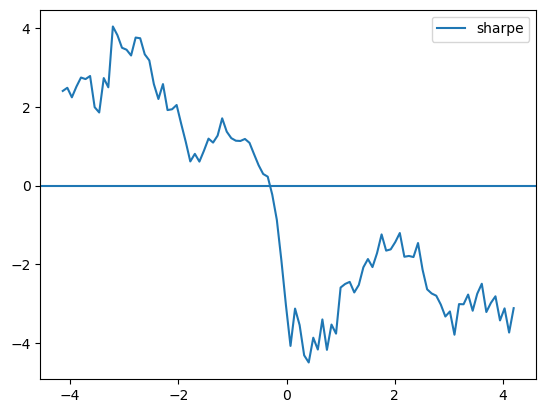

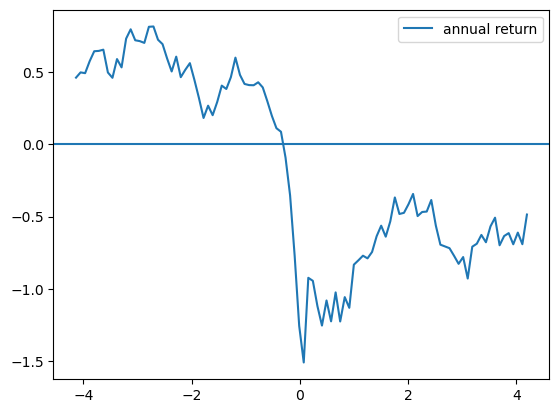

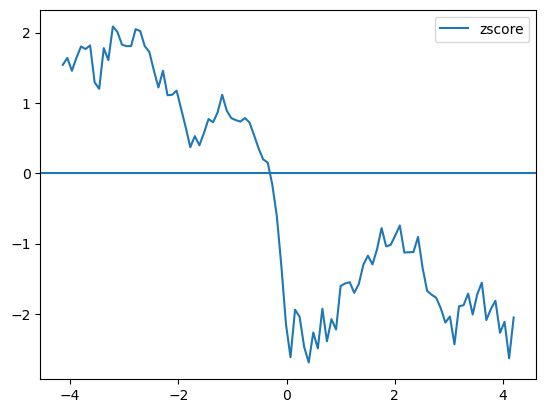

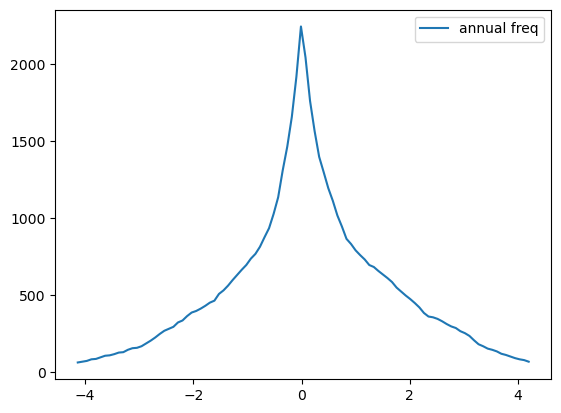

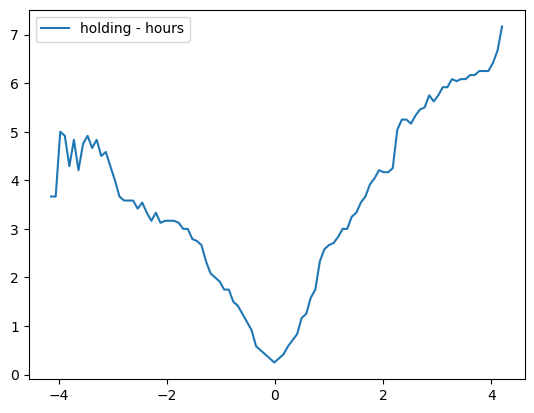

(-4.137565    1.108325
 -4.053391    1.235327
 -3.969217    1.103081
 -3.885044    1.445508
 -3.800870    1.766411
                ...   
  3.858958   -0.000000
  3.943132   -0.000000
  4.027305   -0.000000
  4.111479   -0.000000
  4.195653   -0.000000
 Length: 100, dtype: float64,
 -4.137565    2.405453
 -4.053391    2.485916
 -3.969217    2.243688
 -3.885044    2.515849
 -3.800870    2.746515
                ...   
  3.858958   -2.812656
  3.943132   -3.425396
  4.027305   -3.119424
  4.111479   -3.734126
  4.195653   -3.114026
 Length: 100, dtype: float64,
 -4.137565    0.460755
 -4.053391    0.496930
 -3.969217    0.491637
 -3.885044    0.574561
 -3.800870    0.643146
                ...   
  3.858958   -0.613771
  3.943132   -0.690997
  4.027305   -0.610273
  4.111479   -0.690478
  4.195653   -0.485396
 Length: 100, dtype: float64)

In [75]:
getFeatUtility_pairDE (feat[trainStart:trainEnd], beta, spread, df1, df2, entry_quantiles, 'downward', exit_thres1, 'upward', exit_thres2, 'downward', trainDays, tradingDays, commission, 0, visual=True,minVol=minVol, vol = spread['vol'],)


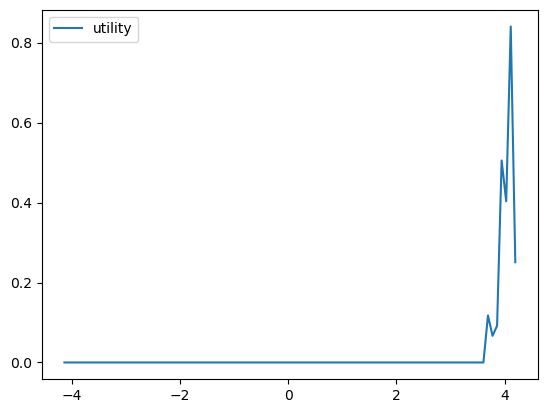

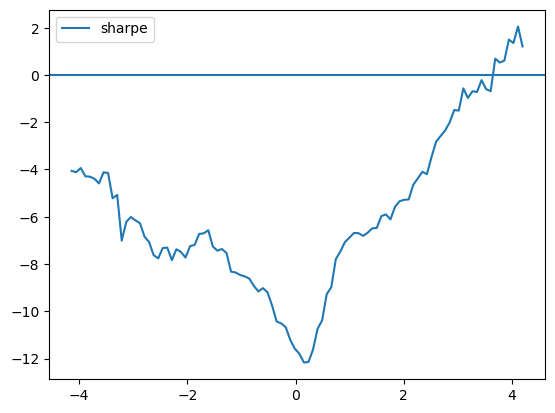

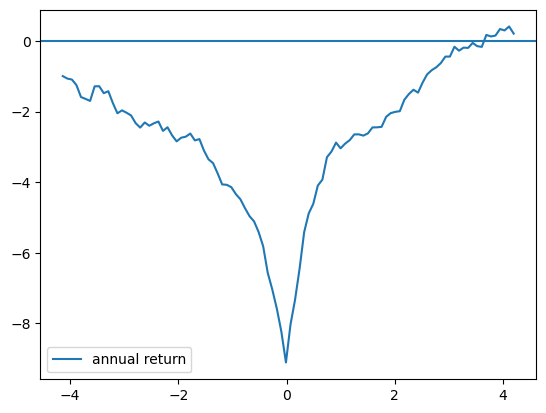

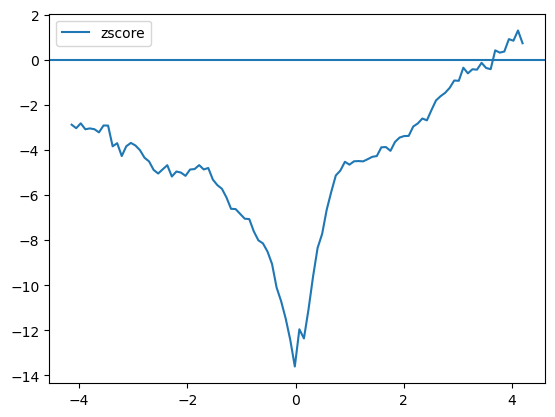

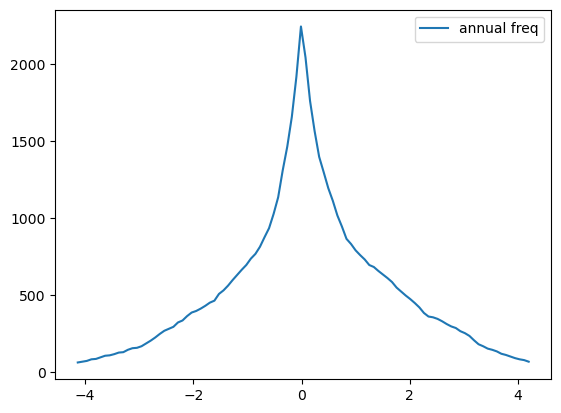

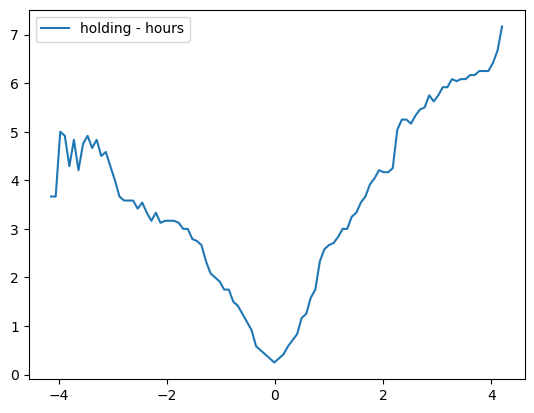

(-4.137565   -0.000000
 -4.053391   -0.000000
 -3.969217   -0.000000
 -3.885044   -0.000000
 -3.800870   -0.000000
                ...   
  3.858958    0.091846
  3.943132    0.505134
  4.027305    0.403116
  4.111479    0.840246
  4.195653    0.250701
 Length: 100, dtype: float64,
 -4.137565   -4.059017
 -4.053391   -4.116389
 -3.969217   -3.938690
 -3.885044   -4.288445
 -3.800870   -4.303637
                ...   
  3.858958    0.604938
  3.943132    1.495149
  4.027305    1.351974
  4.111479    2.050901
  4.195653    1.206408
 Length: 100, dtype: float64,
 -4.137565   -0.995019
 -4.053391   -1.065496
 -3.969217   -1.092434
 -3.885044   -1.249501
 -3.800870   -1.588612
                ...   
  3.858958    0.151827
  3.943132    0.337849
  4.027305    0.298168
  4.111479    0.409696
  4.195653    0.207808
 Length: 100, dtype: float64)

In [76]:
getFeatUtility_pairDE (feat[trainStart:trainEnd], 1/beta, spread, df2, df1, entry_quantiles, 'downward', exit_thres1, 'upward', exit_thres2, 'downward', trainDays, tradingDays, commission, 0, visual=True,minVol=minVol, vol = spread['vol'],)


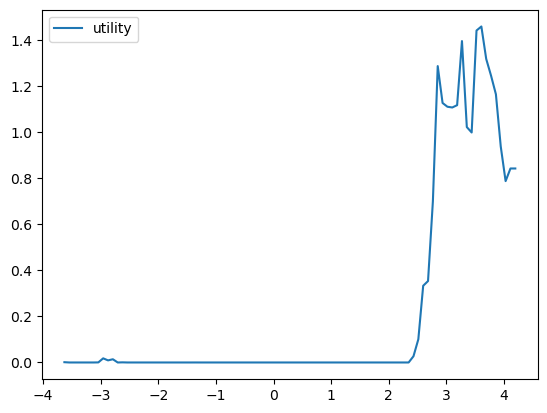

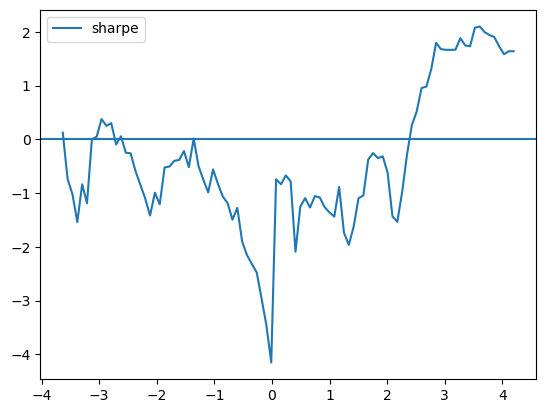

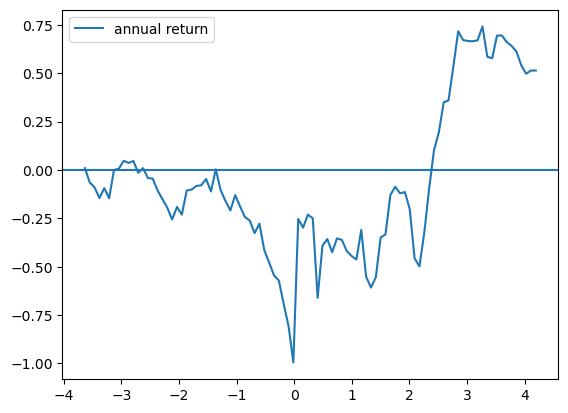

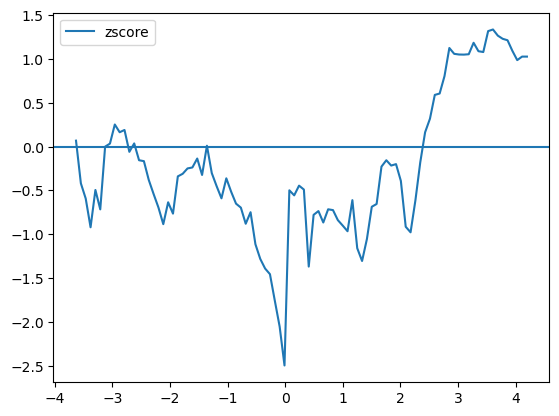

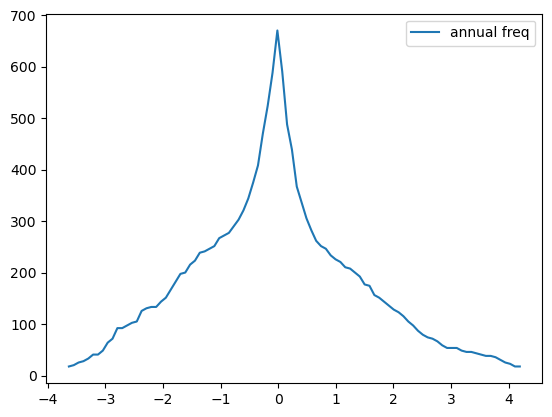

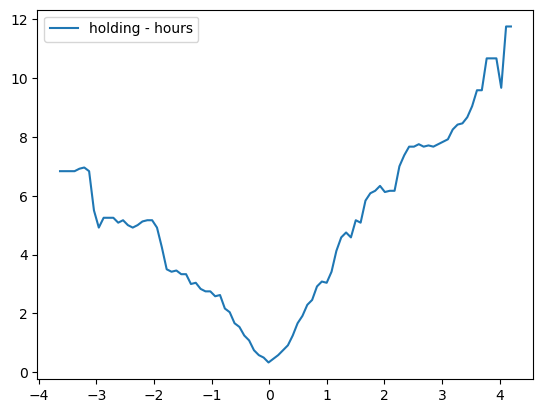

(-4.137565         NaN
 -4.053391         NaN
 -3.969217         NaN
 -3.885044         NaN
 -3.800870         NaN
                ...   
  3.858958    1.165758
  3.943132    0.938547
  4.027305    0.788329
  4.111479    0.843240
  4.195653    0.843240
 Length: 100, dtype: float64,
 -4.137565         NaN
 -4.053391         NaN
 -3.969217         NaN
 -3.885044         NaN
 -3.800870         NaN
                ...   
  3.858958    1.903297
  3.943132    1.732133
  4.027305    1.583914
  4.111479    1.639848
  4.195653    1.639848
 Length: 100, dtype: float64,
 -4.137565         NaN
 -4.053391         NaN
 -3.969217         NaN
 -3.885044         NaN
 -3.800870         NaN
                ...   
  3.858958    0.612494
  3.943132    0.541844
  4.027305    0.497709
  4.111479    0.514218
  4.195653    0.514218
 Length: 100, dtype: float64)

In [77]:
getFeatUtility_pairDE (feat[testStart:testEnd], beta, spread, df1, df2, entry_quantiles, 'downward', exit_thres1, 'upward', exit_thres2, 'downward', trainDays, tradingDays, commission, 0, visual=True,minVol=minVol, vol = spread['vol'],)

In [99]:
# lookback = 100
# commission = 0.001
# feat = getBollinger(spread.Close, lookback, use_log = False)
events = getCrossingEvents_dynamicExit(feat, spread, entry_thres=-3, exit_thres1=3, entry_cross='downward', exit_cross1='upward', 
                                       exit_thres2 = -7, exit_cross2='downward', mid= 0, minVol = minVol,vol=spread['vol'])
ret1 = get_lrets(events, df1, commission = commission, side='long', betSize = 1)
ret2 = get_lrets(events, df2, commission = commission, side='short', betSize = beta)
ret = ret1 + ret2

lev_adj = spread['vol'][ret.index]/targetVol
ret = np.log((np.exp(ret)-1)/lev_adj + 1)

<Axes: xlabel='Time'>

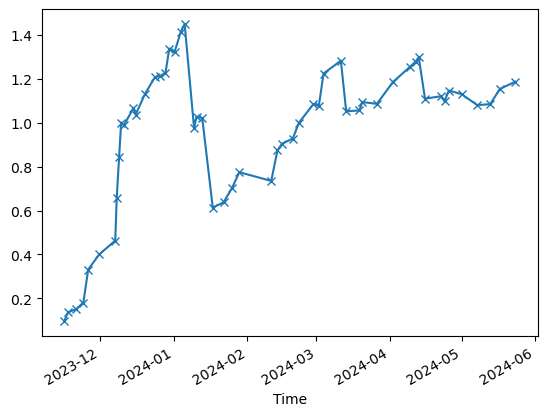

In [100]:
ret.cumsum().plot(marker='x')

<Axes: xlabel='Time'>

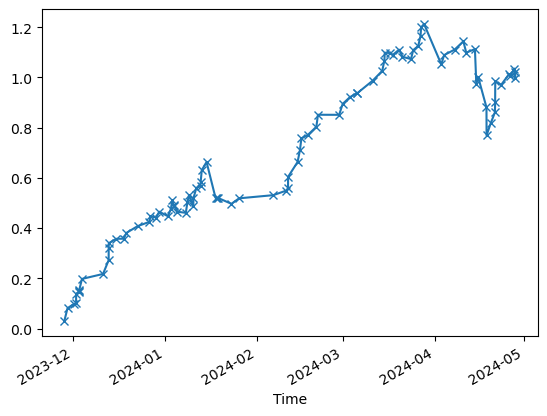

In [68]:
ret.cumsum().plot(marker='x')

<Axes: xlabel='Time'>

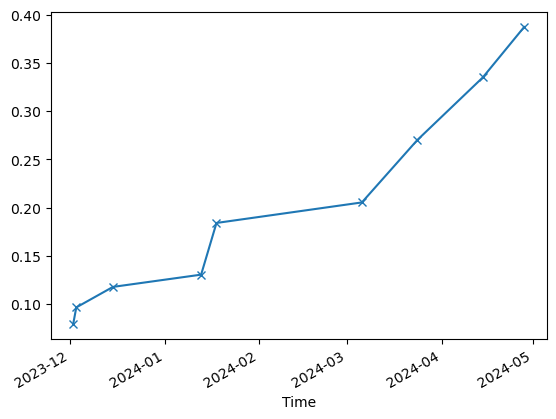

In [ ]:
ret.cumsum().plot(marker='x')

<Axes: xlabel='Time'>

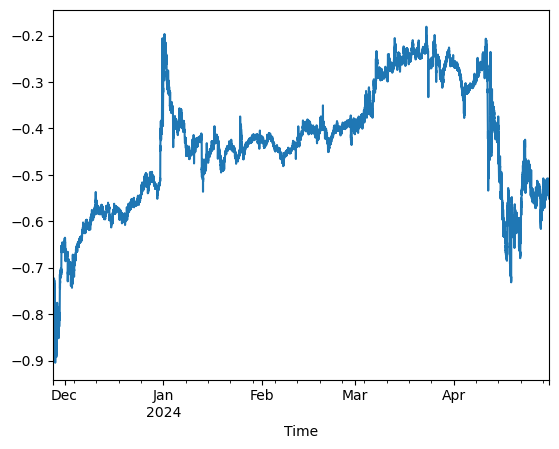

In [529]:
spread.Close.plot()

<Axes: xlabel='Time'>

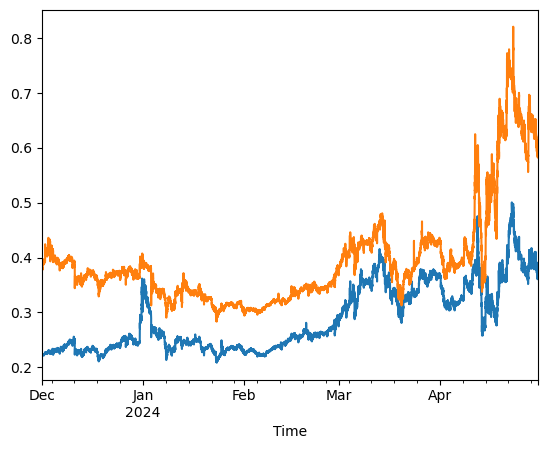

In [235]:
df1.Close.plot();df2.Close.plot()

In [ ]:
ret[trainStart_recent:trainEnd].cumsum().plot()

In [ ]:
out.append(ret[testStart:testEnd])

In [ ]:
combined = pd.concat(out,axis = 0).sort_index()

In [ ]:
# Build Feature for pair
# Feature Library
# 13개
def add_featureSet_pairA (X, tEvent, df_spread, scale, lookback):
    # For Pair, don't use log because spread is already a log
    print(f'Adding Pair Features Set A with lookback={lookback} and scale= {scale}')
    close_path = getPathMatrix(df_spread.Close, tEvent, nbars = lookback, scale = scale)
    lrets_path = close_path.diff(axis=1)
    
    X[f'sharpe1_{scale}'] = (lrets_path.sum(axis=1)/np.sqrt((lrets_path**2).sum(axis=1)))
    X[f'sharpe2_{scale}'] = (lrets_path.sum(axis=1)/lrets_path.std(axis=1))
    X[f'returns_{scale}'] = lrets_path.sum(axis=1)
    X[f'std_{scale}'] = lrets_path.std(axis=1)
    X[f'vol_{scale}'] = np.sqrt((lrets_path**2).sum(axis=1))

    X[f'blgr_{scale}'] = getBollinger(df_spread.Close, lookback*scale, use_log = False)[tEvent]
    X[f'trend_{scale}'] = getTrend(tEvent, df_spread.Close, lookback, scale = scale, use_log=False)
    X[f'trendblgr_{scale}'] = getTrendBlgr(tEvent, df_spread.Close, lookback, scale = scale, use_log=False)
    X[f'willR_{scale}'] = williamsR(df_spread.Close, lookback*scale, nFrac=10)[tEvent]

    X[f'ar1_{scale}'] = getAR1(tEvent, df_spread.Close, lookback, scale=scale, use_log=False)
    X[f'adf_{scale}'] = getADF(tEvent, df_spread.Close, lookback, scale=scale,  constant ='c', lags = int(lookback*0.1), use_log=False)                      

    X[f'macd_norm1_{scale}'] = getMACD_norm(df_spread.Close, span_short = scale*lookback//4, span_long = scale*lookback//2, use_ewm = False, use_log=False)[tEvent]
    X[f'macd_norm2_{scale}'] = getMACD_norm(df_spread.Close, span_short = scale*lookback//2, span_long = scale*lookback, use_ewm = False,use_log=False)[tEvent]
    return X

def add_featureSet_pairB (X, tEvent, df1, df2, scale, lookback):
    print(f'Adding Pair Features Set B with lookback={lookback} and scale= {scale}')
    close1 = getPathMatrix(df1.Close, tEvent, nbars = lookback, scale = scale)
    close2 = getPathMatrix(df2.Close, tEvent, nbars = lookback, scale = scale)

    slopes, intercepts, residuals = rowwise_regression(X=np.log(close2), Y=np.log(close1))
    X[f'beta_{scale}'] = slopes
    X[f'beta_residual_{scale}'] = residuals
    X[f'beta_norm_{scale}'] = slopes/residuals
    X[f'intercept_{scale}'] = intercepts
    return X

def add_featureSetA (X, tEvent, df, scale, lookback, name = ''):
    print(f'Adding Feature Set A with lookback={lookback} and scale = {scale}')
    close_path = getPathMatrix(df.Close, tEvent, nbars = lookback, scale = scale)
    lrets_path = np.log(close_path).diff(axis=1)
    
    X[f'sharpe1_{scale}{name}'] = (lrets_path.sum(axis=1)/np.sqrt((lrets_path**2).sum(axis=1)))
    X[f'sharpe2_{scale}{name}'] = (lrets_path.sum(axis=1)/lrets_path.std(axis=1))
    X[f'returns_{scale}{name}'] = lrets_path.sum(axis=1)
    X[f'std_{scale}{name}'] = lrets_path.std(axis=1)
    X[f'vol_{scale}'] = np.sqrt((lrets_path**2).sum(axis=1))

    X[f'blgr_{scale}{name}'] = getBollinger(df.Close, lookback*scale)[tEvent]
    X[f'trend_{scale}{name}'] = getTrend(tEvent, df.Close, lookback, scale = scale, use_log=True)
    X[f'trendblgr_{scale}{name}'] = getTrendBlgr(tEvent, df.Close, lookback, scale = scale, use_log=True)
    X[f'willR_{scale}{name}'] = williamsR(df.Close, lookback*scale, nFrac=10)[tEvent]

    X[f'ar1_{scale}{name}'] = getAR1(tEvent, df.Close, lookback, scale=scale, use_log=True)
    X[f'adf_{scale}{name}'] = getADF(tEvent, df.Close, lookback, scale=scale,  constant ='c', lags = int(lookback*0.1),)                      

    X[f'macd_norm1_{scale}{name}'] = getMACD_norm(df.Close, span_short = scale*lookback//4, span_long = scale*lookback//2, use_ewm = False)[tEvent]
    X[f'macd_norm2_{scale}{name}'] = getMACD_norm(df.Close, span_short = scale*lookback//2, span_long = scale*lookback, use_ewm = False)[tEvent]
    return X


In [ ]:
X = pd.DataFrame(index = events.index)
# X = add_featureSet_pairA(X, events.index, spread, scale = 1, lookback = 100)
# X = add_featureSet_pairA(X, events.index, spread, scale = 4, lookback = 100)
# X = add_featureSet_pairA(X, events.index, spread, scale = 12, lookback = 100)

# X = add_featureSet_pairB(X, events.index, df1, df2, scale = 1, lookback = 100)
# X = add_featureSet_pairB(X, events.index, df1, df2, scale = 3, lookback = 100)
# X = add_featureSet_pairB(X, events.index, df1, df2, scale = 12, lookback = 100)

X = add_featureSetA(X, events.index, df1, scale = 1, lookback = 100)
X = add_featureSetA(X, events.index, df2, scale = 1, lookback = 100, name = '_2')

X = add_featureSetA(X, events.index, df1, scale = 4, lookback = 100)
X = add_featureSetA(X, events.index, df2, scale = 4, lookback = 100, name = '_2')

X = add_featureSetA(X, events.index, df1, scale = 12, lookback = 100)
X = add_featureSetA(X, events.index, df2, scale = 12, lookback = 100, name = '_2')

In [ ]:
Y = pd.DataFrame(index =ret.index)
Y['cont'] = ret
Y['bin'] = (ret>0).astype(int)
print(X.shape, Y.shape)

X_clean = X.replace([np.inf, -np.inf], np.nan)
X_clean = X_clean.dropna()
intersected_indices = X_clean.index.intersection(Y.index)
Y_clean = Y.loc[intersected_indices]
X_clean = X_clean.loc[intersected_indices]
print(X_clean.shape, Y_clean.shape)

In [ ]:
# X_train, X_test, Y_train, Y_test = X_clean.loc[trainStart_recent:trainEnd], X_clean.loc[testStart:testEnd], Y_clean.loc[trainStart_recent:trainEnd], Y_clean.loc[testStart:testEnd]
X_train, X_test, Y_train, Y_test = X_clean.loc[trainStart:trainEnd], X_clean.loc[testStart:testEnd], Y_clean.loc[trainStart:trainEnd], Y_clean.loc[testStart:testEnd]
print('default precision:', Y_test[Y_test['cont']>0]['cont'].sum()/Y_test['cont'].abs().sum())

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# Initialize the logistic regression model
clf = LogisticRegression(max_iter= 1000, penalty = 'l2', random_state =1, C = .5)

# Train the model
clf.fit(X_train, Y_train.bin, sample_weight = Y_train.cont.abs())
y_proba_test = clf.predict_proba(X_test)[:,1]

In [ ]:
bet_size =np.maximum(2*y_proba_test-1,0)

In [ ]:
# Classification report
y_pred_test = (y_proba_test > 0.5).astype(int)
print("percent of samples:", y_pred_test.sum()/len(y_pred_test)) 
print()
print(classification_report(Y_test['bin'], y_pred_test, sample_weight=Y_test['cont'].abs()))

In [ ]:
# selected = Y_test.cont[y_proba_test>0.6]
selected = np.log((np.exp(Y_test.cont)-1)*bet_size*2+1)
selected.cumsum().plot(label='model')
print(selected.shape)
print(len(ret[testStart:testEnd]))
ret[testStart:testEnd].cumsum().plot(label='default')
plt.legend();plt.show()

In [ ]:
out.append(selected)

In [ ]:
combined = ret[pd.to_datetime("2022-04-01"):]

In [ ]:
combined = pd.concat(out, axis = 0).sort_index()

In [ ]:
combined.cumsum().plot()

In [ ]:
import quantstats as qs
qs.reports.full(np.exp(combined)-1)

In [20]:
# Save Model
import pickle
with open('Analysis/[S2] XRP_XLM_Pair/events.pkl', 'wb') as f:
    pickle.dump(events, f)